## Análisis de los viajes con la tarjeta TFL Oyster
Londres es una de las principales capitales mundiales en muchos sectores, aunque quizás el más notable en las finanzas. Con una economía en auge, la gente está llegando a la ciudad de todo el mundo, atraída por el próspero mercado laboral y los altos estándares de vida.
Esto ha provocado que su población aumente de manera constante desde la década de 1970, y más notablemente desde la de 1990.
En 2011, el Plan Actual de Londres [[1]](https://www.london.gov.uk/what-we-do/planning/london-plan/current-london-plan/london-plan-chapter-one-context-and-strategy-0) predijo:
> ... La población de Londres aumenta de 8,2 millones en 2011, a:
>
>9.20 millones en 2021;
>9.54 millones en 2026;
>9.84 millones en 2031; and
>10.11 millones en 2036.

Hasta ahora, sus estimaciones han demostrado ser precisas; las estimaciones actuales sitúan la población de Londres en alrededor de 9,3 millones. [[2]](https://worldpopulationreview.com/world-cities/london-population/)

Con una población en crecimiento, las carreteras de Londres se están volviendo más congestionadas y la red de TFL está luchando por hacer frente. Nunca fue esto más obvio que en el apogeo de la crisis de COVID-19 a principios de marzo de este año.

En este cuaderno,  se analizará un conjunto de datos que contiene información sobre los viajes de la tarjeta TFL Oyster durante un período de 7 días en noviembre de 2009 para extraer algunas ideas sobre la red TFL y resaltar las áreas problemáticas clave que deben abordarse.

El conjunto de datos fue recopilado por un alumno del Departamento de Física y Astronomía de la UCL, encuéntrelo aquí: [TFL Viajes con Oyster '09](https://www.kaggle.com/astronasko/transport-for-london-journey-information)

<figure>
   <a href="https://www.london.gov.uk/sites/default/files/styles/gla_large_unconstrained/public/figure_1.1_annual_pop_change_1971-2011.png?itok=tmztWl0e">
   <img src=https://www.london.gov.uk/sites/default/files/styles/gla_large_unconstrained/public/figure_1.1_annual_pop_change_1971-2011.png?itok=tmztWl0e width="500" align="center"/></a>
   <figcaption> Cambios en la población de Londres entre 1971-2011. Fuente: london.gov.uk
   </figcaption>
</figure>

In [42]:
# import modules
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile as zp

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [43]:
# Read in dataset
zf = zp.ZipFile ('./input/Nov09JnyExport.zip')
df = pd.read_csv(zf.open('Nov09JnyExport.csv'))

In [44]:
# Check the head of the dataset
df.head()

,downo,daytype,SubSystem,StartStn,EndStation,EntTime,EntTimeHHMM,ExTime,EXTimeHHMM,ZVPPT,JNYTYP,DailyCapping,FFare,DFare,RouteID,FinalProduct
0,3,Tue,LUL,Unstarted,Kings Cross M,0,00:00,633,10:33,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
1,4,Wed,LUL,Unstarted,Sudbury Hill,0,00:00,447,07:27,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
2,3,Tue,NR,Unstarted,Richmond,0,00:00,966,16:06,Z0304,TKT,N,0,0,XX,LUL Travelcard-7 Day
3,4,Wed,NR,Unstarted,Romford,0,00:00,657,10:57,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
4,6,Fri,NR,Unstarted,Norwood Junction SR,0,00:00,450,07:30,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2623487 entries, 0 to 2623486
Data columns (total 16 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   downo         int64 
 1   daytype       object
 2   SubSystem     object
 3   StartStn      object
 4   EndStation    object
 5   EntTime       int64 
 6   EntTimeHHMM   object
 7   ExTime        int64 
 8   EXTimeHHMM    object
 9   ZVPPT         object
 10  JNYTYP        object
 11  DailyCapping  object
 12  FFare         int64 
 13  DFare         int64 
 14  RouteID       object
 15  FinalProduct  object
dtypes: int64(5), object(11)
memory usage: 320.2+ MB


# Paso 1: Adecuación de Datos
* Primero, se limpiaran y reformatearan los datos para que se adapten a los propósitos del anánlisis..
* Se comenzará cambiando el nombre de algunas columnas para hacerlas más descriptivas y consistentes.

In [46]:
df = df.rename(columns={'downo': 'DOWno', 'daytype': 'DOW', 'EndStation': 'EndStn',
                        'EXTimeHHMM': 'ExTimeHHMM', 'ZVPPT': 'Zones', 'JNYTYP': 'JourneyType',
                        'FFare': 'FullFare', 'DFare': 'DiscountFare', 'RouteID': 'BusRoute'})

In [47]:
df['EntTimeHHMM'].value_counts()

00:00    45989
08:12     4429
08:16     4391
08:09     4334
08:10     4334
         ...  
27:25       56
04:31       52
26:36       50
04:08        1
01:42        1
Name: EntTimeHHMM, Length: 1443, dtype: int64

In [48]:
df['ExTimeHHMM'].value_counts()

00:00    1812168
08:59       1962
08:48       1912
08:49       1865
08:50       1859
          ...   
02:36          1
26:14          1
04:56          1
02:37          1
05:14          1
Name: ExTimeHHMM, Length: 1230, dtype: int64

* Con mucho, el valor más frecuente para ambos'EntTimeHHMM' y 'ExTimeHHMM' es 00:00
* Esto parece erróneo, ya que uno esperaría que la mayoría de los pasajeros viajen en horas pico. (antes 9am, después 5pm)
* Se inspeccionará esto más a fondo y posiblemente se eliminaran estas dos columnas, ya que las columnas 'EntTime' y 'ExTime' proporcionan información suficiente (tiempo en minutos después de la medianoche)

In [49]:
df[df['EntTimeHHMM'] != '00:00']['EntTimeHHMM'].value_counts().head(30)

08:12    4429
08:16    4391
08:10    4334
08:09    4334
08:19    4322
08:14    4296
08:13    4276
08:05    4271
08:07    4264
08:15    4256
08:08    4243
08:11    4242
08:17    4233
08:06    4191
08:04    4187
08:21    4182
17:09    4158
17:11    4139
08:01    4133
17:08    4128
08:24    4124
08:02    4092
17:07    4087
08:20    4084
08:22    4084
17:42    4074
08:27    4061
08:03    4050
08:26    4049
17:10    4048
Name: EntTimeHHMM, dtype: int64

In [50]:
df[df['EntTimeHHMM'] != '00:00']['EntTimeHHMM'].value_counts().tail(30)

27:24    72
27:49    72
26:46    72
27:47    72
27:01    71
27:17    71
26:26    71
26:06    70
27:51    69
26:48    69
26:53    69
27:37    68
27:36    68
26:40    67
26:28    67
27:44    66
27:08    66
27:58    65
27:43    65
26:34    65
26:51    63
27:35    62
27:11    62
27:27    60
26:45    60
27:25    56
04:31    52
26:36    50
01:42     1
04:08     1
Name: EntTimeHHMM, dtype: int64

In [51]:
df[df['EntTimeHHMM'] == '27:25']

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,EntTimeHHMM,ExTime,ExTimeHHMM,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,BusRoute,FinalProduct
951615,5,Thu,LTB,Bus,Bus,1645,27:25,0,00:00,-------,PPY,Y,100,30,N35,PAYG
951616,5,Thu,LTB,Bus,Bus,1645,27:25,0,00:00,B0104,TKT,N,0,0,N27,Bus & Tram Pass-7 Day
951617,6,Fri,LTB,Bus,Bus,1645,27:25,0,00:00,B0104,TKT,N,0,0,N3,Bus & Tram Pass-7 Day
951618,7,Sat,LTB,Bus,Bus,1645,27:25,0,00:00,Z0203,TKT,N,0,0,188,LUL Travelcard-1 Month
951619,4,Wed,LTB,Bus,Bus,1645,27:25,0,00:00,-------,PPY,N,100,100,N189,PAYG
951620,6,Fri,LTB,Bus,Bus,1645,27:25,0,00:00,-------,PPY,N,100,100,N102,PAYG
951621,4,Wed,LTB,Bus,Bus,1645,27:25,0,00:00,B0104,TKT,N,0,0,N25,Bus & Tram Pass-7 Day
951622,1,Sun,LTB,Bus,Bus,1645,27:25,0,00:00,Z0203,TKT,N,0,0,N18,LUL Travelcard-7 Day
951623,2,Mon,LTB,Bus,Bus,1645,27:25,0,00:00,Z0203,TKT,N,0,0,N18,LUL Travelcard-7 Day
951624,3,Tue,LTB,Bus,Bus,1645,27:25,0,00:00,B0104,TKT,N,0,0,N21,Bus & Tram Pass-7 Day


In [52]:
df[(df['EntTimeHHMM'] == '26:36')]

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,EntTimeHHMM,ExTime,ExTimeHHMM,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,BusRoute,FinalProduct
947808,6,Fri,LTB,Bus,Bus,1596,26:36,0,00:00,-------,PPY,N,0,0,N2,PAYG
947809,6,Fri,LTB,Bus,Bus,1596,26:36,0,00:00,B0104,TKT,N,0,0,N16,Bus & Tram Pass-7 Day
947810,4,Wed,LTB,Bus,Bus,1596,26:36,0,00:00,-------,PPY,N,100,100,N97,PAYG
947811,1,Sun,LTB,Bus,Bus,1596,26:36,0,00:00,Z0203,TKT,N,0,0,N87,LUL Travelcard-7 Day
947812,6,Fri,LTB,Bus,Bus,1596,26:36,0,00:00,B0104,TKT,N,0,0,N91,Bus & Tram Pass-7 Day
947813,7,Sat,LTB,Bus,Bus,1596,26:36,0,00:00,-------,PPY,N,100,100,N214,PAYG
947814,4,Wed,LTB,Bus,Bus,1596,26:36,0,00:00,Z0203,TKT,N,0,0,N86,LUL Travelcard-7 Day
947815,3,Tue,LTB,Bus,Bus,1596,26:36,0,00:00,-------,PPY,Y,100,0,N20,PAYG
947816,6,Fri,LTB,Bus,Bus,1596,26:36,0,00:00,Z0103,TKT,N,0,0,N279,LUL Travelcard-7 Day
947817,5,Thu,LTB,Bus,Bus,1596,26:36,0,00:00,-------,PPY,N,100,100,N98,PAYG


### Algunas observaciones sobre 'EntTimeHHMM' y 'ExTimeHHMM'
* Como era de esperar, la gran mayoría de los viajes (excepto en la hora predeterminada de las 00:00) se realizan entre las 08: 00-09: 00 o las 17: 00-18: 00, que es la hora pico en Londres.
* Todas las entradas erróneas donde HH> 23 son viajes en autobús en rutas nocturnas (incluidas rutas de 24 horas como la ruta 83), como se evidencia en las tablas anteriores (por ejemplo, N295 en el índice 947857)
* Estas dos categorías no brindan una perspectiva única que no se pueda derivar de otras categorías, como 'EntTime' y 'ExTime', y son demasiado complicadas. Por tanto, ambas seran descartadas.

In [53]:
df = df.drop(['EntTimeHHMM', 'ExTimeHHMM'], axis=1)

* Ahora revisaremos las entradas para las categorías restantes

In [54]:
# El autobús o colectivo es, con mucho, el modo de transporte más popular (al menos para viajes con tarjeta Oyster)
df['SubSystem'].value_counts()

LTB           1768080
LUL            723126
NR              47715
LUL/NR          25990
LUL/DLR         13911
TRAM             9583
DLR              9224
LUL/NR/LRC       8262
NR/LRC           6665
LRC              3713
LUL/LRC          3293
LUL/NR/DLR       2812
HEX               760
NR/DLR            263
LUL/TRAM           86
DLR/LRC             4
Name: SubSystem, dtype: int64

In [55]:
print(sorted(df['StartStn'].unique()))

['ADDISCOMBE TRAM               ', 'ADDNGTN VIL TRAM              ', 'AMPERE WAY TRAM               ', 'ARENA TRAM                    ', 'AVENUE ROAD TRAM              ', 'Acton Central', 'Acton Main Line', 'Acton Town', 'Aldgate', 'Aldgate East', 'All Saints', 'Alperton', 'Amersham', 'Angel', 'Archway', 'Arnos Grove', 'Arsenal', 'BECKENHM JN TRAM              ', 'BECKENHM RD TRAM              ', 'BEDDNGTN LN TRAM              ', 'BELGRAVE WK TRAM              ', 'BIRKBECK TRAM                 ', 'BLCKHRS LNE TRAM              ', 'Baker Street', 'Balham', 'Balham NR', 'Bank', 'Barbican', 'Barking', 'Barkingside', 'Barons Court', 'Battersea Park', 'Bayswater', 'Beckton', 'Beckton Park', 'Becontree', 'Bellingham', 'Belsize Park', 'Bermondsey', 'Bethnal Green', 'Bethnal Green NR', 'Blackfriars', 'Blackhorse Road', 'Blackwall', 'Bond Street', 'Borough', 'Boston Manor', 'Bounds Green', 'Bow Church', 'Bow Road', 'Brent Cross', 'Brixton', 'Brockley', 'Bromley By Bow', 'Brondesbury', 'Brondesb

In [56]:
print(sorted(df['EndStn'].unique()))

['Acton Central', 'Acton Main Line', 'Acton Town', 'Aldgate', 'Aldgate East', 'All Saints', 'Alperton', 'Amersham', 'Angel', 'Archway', 'Arnos Grove', 'Arsenal', 'Baker Street', 'Balham', 'Balham SCL', 'Bank', 'Barbican', 'Barking', 'Barkingside', 'Barons Court', 'Battersea Park', 'Bayswater', 'Beckton', 'Beckton Park', 'Becontree', 'Belsize Park', 'Bermondsey', 'Bethnal Green', 'Bethnal Green NR', 'Blackfriars', 'Blackhorse Road', 'Blackwall', 'Bond Street', 'Borough', 'Boston Manor', 'Bounds Green', 'Bow Church', 'Bow Road', 'Brent Cross', 'Brixton', 'Brockley', 'Bromley By Bow', 'Brondesbury', 'Brondesbury Park', 'Buckhurst Hill', 'Burnt Oak', 'Bus', 'Bushey', "Caledonian Rd&B'sby", 'Caledonian Road', 'Cambridge Heath', 'Camden Road', 'Camden Town', 'Canada Water', 'Canary Wharf', 'Canary Wharf DLR', 'Canary Wharf E2', 'Canning Town', 'Cannon Street', 'Canonbury', 'Canons Park', 'Carpenders Park', 'Carshalton', 'Castle Bar Park', 'Chalfont & Latimer', 'Chalk Farm', 'Chancery Lane', 

* Al observar los nombres únicos de las estaciones en 'StartStn', podemos ver que algunos pasajeros no pasaron la tarjeta, lo que resultó en el nombre de estación predeterminado 'Unstarted'
* Al hacer lo mismo para 'EndStn', encontramos que los viajes en los que el pasajero no pasó la tarjeta reciben el nombre de estación predeterminado 'Sin terminar'

## Viajes Completos
* Nos interesa explorar la duración del viaje y cómo interactúa con otras variables..
* Para hacer esto, craremos un nuevo set de datos llamado 'complete', que es un subconjunto de 'df', pero solo contiene entradas donde el pasajero pasó la tarjeta tanto al subir como al bajar (es decir, conocemos su estación de inicio y finalización).

In [57]:
complete = df[(df['StartStn'] != 'Unstarted') & (df['EndStn'] != 'Unfinished')]

In [58]:
complete.head()

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,ExTime,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,BusRoute,FinalProduct
45989,2,Mon,LUL,Goodge Street,Totteridge,1000,1041,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
45990,6,Fri,LTB,Bus,Bus,1000,0,Z0102,TKT,N,0,0,242,LUL Travelcard-7 Day
45991,5,Thu,LTB,Bus,Bus,1000,0,B0104,TKT,N,0,0,16,Bus & Tram Pass-1 Month
45992,6,Fri,LTB,Bus,Bus,1000,0,Z0203,TKT,N,0,0,254,LUL Travelcard-7 Day
45993,7,Sat,LTB,Bus,Bus,1000,0,-------,PPY,N,100,100,474,PAYG


In [59]:
complete.sample()

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,ExTime,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,BusRoute,FinalProduct
1594313,6,Fri,LTB,Bus,Bus,592,0,Z0203,TKT,N,0,0,260,LUL Travelcard-1 Month


* Al observar los subconjuntos de datos de 'completo', es evidente que todos los viajes en autobús tienen una hora de salida predeterminada de medianoche. Esto tiene sentido, ya que no se requiere que los pasajeros que viajan en autobús, pases su tarjeta al bajar, por lo que no habrá información sobre la hora final de su viaje. Para nuestros propósitos, esto no es útil, ya que estamos tratando de analizar los tiempos de viaje.
* Otra observación es que para algunos viajes en autobús, la estación de inicio y la estación final son ambas 'Bus' por defecto.
* Por esta razón, se eliminaran todos los viajes en autobús del subconjunto 'complete'.

In [60]:
# drop all bus journeys from complete
complete = complete[complete['SubSystem'] != 'LTB']

* Como se han eliminado todos los viajes en autobús, la columna 'BusRoute' ahora es redundante, ya que todas las entradas serán 'XX' por defecto. Eliminaremos a continuación esta columna.

In [61]:
complete = complete.drop('BusRoute', axis=1)

### Ingeniería de características propias del proyecto
A continuación, se creará una nueva categoría llamada "JourneyTime ", que es el tiempo total de viaje en minutos, como la diferencia entre"ExTime" and "EntTime"

In [62]:
complete['JourneyLength'] = complete['ExTime'] - complete['EntTime']

In [63]:
complete[complete['JourneyLength'] <= 0]

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,ExTime,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,FinalProduct,JourneyLength
46362,2,Mon,TRAM,WADDON MARSH TRAM,Not Applicable,1000,0,Z0104,TKT,N,0,0,Bus & Tram Pass-1 Month,-1000
46516,7,Sat,TRAM,WELLESLY RD TRAM,Not Applicable,1000,0,Z0104,TKT,N,0,0,Bus & Tram Pass-7 Day,-1000
47399,3,Tue,TRAM,THERAPIA LN TRAM,Not Applicable,1000,0,-------,PPY,N,0,0,PAYG,-1000
47574,5,Thu,TRAM,THERAPIA LN TRAM,Not Applicable,1000,0,Z0110,TKT,N,0,0,Freedom Pass (Elderly),-1000
47682,2,Mon,TRAM,EAST CROYDON TRAM,Not Applicable,1000,0,-------,PPY,N,100,100,PAYG,-1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2623004,5,Thu,TRAM,EAST CROYDON TRAM,Not Applicable,999,0,-------,PPY,N,0,0,PAYG,-999
2623088,2,Mon,TRAM,ELMERS END TRAM,Not Applicable,999,0,Z0104,TKT,N,0,0,Bus & Tram Pass-7 Day,-999
2623225,6,Fri,TRAM,MORDEN ROAD TRAM,Not Applicable,999,0,Z0203,TKT,N,0,0,LUL Travelcard-7 Day,-999
2623443,6,Fri,TRAM,WIMBLEDON TRAM,Not Applicable,999,0,-------,PPY,N,0,0,PAYG,-999


* Mirando 'JourneyTime', encontramos que todos los viajes en tranvía (TRAM) siguen el mismo patrón que los viajes en autobús, con una hora de salida predeterminada de medianoche. Esto no es útil para nuestros propósitos, por lo que ahora eliminamos todos los viajes en tranvía.

In [64]:
complete = complete[complete['SubSystem'] != 'TRAM']

In [65]:
complete[complete['JourneyLength'] <= 0]

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,ExTime,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,FinalProduct,JourneyLength
48078,3,Tue,LUL,Oxford Circus,Oxford Circus,1000,1000,-------,PPY,N,0,0,PAYG,0
51353,3,Tue,LUL,Holborn,Holborn,1001,1001,-------,PPY,N,0,0,PAYG,0
51397,7,Sat,LUL,Notting Hill Gate,Notting Hill Gate,1001,1001,-------,PPY,N,400,400,PAYG,0
54697,3,Tue,LUL,Holborn,Holborn,1002,1002,-------,PPY,N,0,0,PAYG,0
59721,7,Sat,LUL,Balham,Balham,1004,1004,-------,PPY,N,0,0,PAYG,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2586350,7,Sat,LUL,Westminster,Westminster,988,988,-------,PPY,N,400,400,PAYG,0
2587209,5,Thu,NR,East Croydon,East Croydon,989,989,Z0110,TKT,N,0,0,Freedom Pass (Elderly),0
2587437,6,Fri,LUL,Stamford Brook,Stamford Brook,989,989,-------,PPY,N,400,400,PAYG,0
2592585,4,Wed,LUL/NR/DLR,Stratford,Stratford,990,990,-------,PPY,N,0,0,PAYG,0


In [66]:
complete[complete['JourneyLength'] <= 0].sample()

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,ExTime,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,FinalProduct,JourneyLength
1746712,1,Sun,LUL/NR,Kings Cross T,Kings Cross T,667,667,-------,PPY,N,0,0,PAYG,0


* Por último, encontramos que quedan 724 entradas en las que 'JourneyTime' es menor o igual a cero. Todas parecen ser donde un pasajero ha entrado y salido de la misma estación, por lo que ahora eliminamos las entradas donde la estación de inicio y la estación final son iguales

In [67]:
complete = complete[complete['StartStn'] != complete['EndStn']]

In [68]:
complete[complete['JourneyLength'] <= 0]

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,ExTime,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,FinalProduct,JourneyLength
93546,7,Sat,NR,Balham NR,Balham SCL,1014,1014,Z0103,TKT,N,0,0,LUL Travelcard-1 Month,0
172562,2,Mon,LUL,Canary Wharf E2,Canary Wharf,1035,1035,-------,PPY,N,110,110,PAYG,0
211864,4,Wed,NR,Balham NR,Balham SCL,1045,1045,Z0104,TKT,N,0,0,LUL Travelcard-1 Month,0
282008,2,Mon,LUL,Southfields,Not Applicable,1064,967,-------,PPY,N,0,0,PAYG,-97
391984,5,Thu,NR,Liverpool St NR,Liverpool St WAGN TOC Gates,1094,1094,-------,PPY,N,0,0,PAYG,0
404334,7,Sat,LUL,Canary Wharf E2,Canary Wharf,1097,1097,Z0203,TKT,N,0,0,LUL Travelcard-7 Day,0
419315,5,Thu,LUL,Canary Wharf E2,Canary Wharf,1101,1101,Z0110,TKT,N,0,0,Freedom Pass (Elderly),0
530345,5,Thu,NR,Balham NR,Balham SCL,1139,1139,Z0103,TKT,N,0,0,LUL Travelcard-7 Day,0
560067,5,Thu,NR,Liverpool St NR,Liverpool St WAGN TOC Gates,1150,1150,-------,PPY,N,0,0,PAYG,0
566531,6,Fri,NR,Liverpool St NR,Liverpool St WAGN TOC Gates,1153,1153,-------,PPY,N,0,0,PAYG,0


In [69]:
print(f"Viajes restantes con tiempo de viaje inválidos: {len(complete[complete['JourneyLength'] <= 0])}")

Viajes restantes con tiempo de viaje inválidos: 46


* Por último, tenemos 46 entradas restantes donde 'JourneyTime' es menor o igual a cero. Todos estos son casos en los que la estación inicial y final son iguales, por lo que serán eliminados.

In [70]:
complete = complete[complete['JourneyLength'] > 0]

In [71]:
complete.describe()

,DOWno,EntTime,ExTime,FullFare,DiscountFare,JourneyLength
count,759367.000000,759367.000000,759367.000000,759367.000000,759367.000000,759367.000000
mean,4.133289,857.696776,885.170729,93.727262,91.213340,27.473953
std,1.728057,290.694861,290.405064,103.348382,102.697016,15.295672
min,1.000000,248.000000,300.000000,0.000000,0.000000,1.000000
25%,3.000000,557.000000,584.000000,0.000000,0.000000,16.000000
50%,4.000000,904.000000,929.000000,55.000000,55.000000,25.000000
75%,6.000000,1088.000000,1116.000000,160.000000,160.000000,36.000000
max,7.000000,1503.000000,1526.000000,700.000000,700.000000,162.000000


# Paso 2: EDA (Análisis Exploratorio de Datos)
Ahora exploremos los datos con algunas visualizaciones.

In [72]:
complete['SubSystem'].value_counts()

LUL           675277
LUL/NR         24116
NR             16408
LUL/DLR        13910
DLR             7962
LUL/NR/LRC      7945
NR/LRC          5788
LRC             3230
LUL/LRC         3014
HEX              745
LUL/NR/DLR       619
NR/DLR           263
LUL/TRAM          86
DLR/LRC            4
Name: SubSystem, dtype: int64

<AxesSubplot:title={'center':'Número de viajes por modalidad de transporte'}>

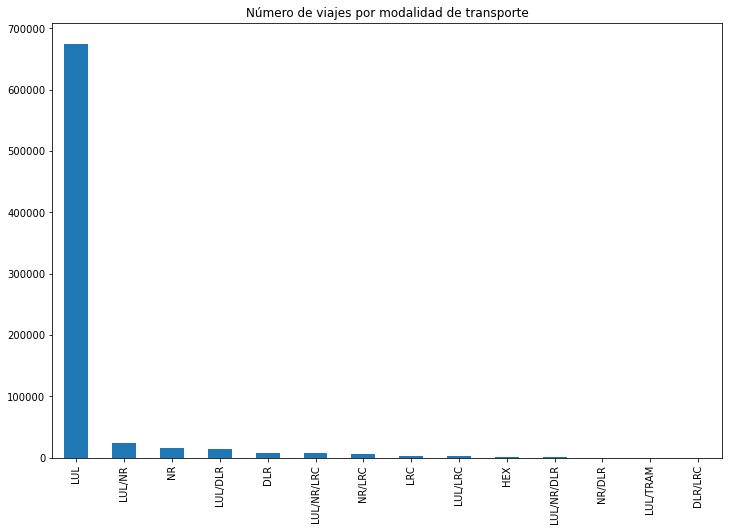

In [73]:
fig = plt.figure(figsize=[12,8])
plt.title('Número de viajes por modalidad de transporte')
complete['SubSystem'].value_counts().plot(kind='bar')

## Observación importante sobre el marco de datos 'complete'
* LUL (Subterráneo) es, con mucho, el modo de transporte más destacado. Esto nos dice que el marco de datos 'complete' no es indicativo de todos los viajes de Oyster, ya que parecería que la información completa del viaje solo está disponible para LUL. Eliminamos todas las entradas de otros modos de transporte, sobre todo el autobús, que era, con mucho, el modo de transporte más popular.
* Por lo tanto, es importante tener en cuenta que las predicciones y conclusiones que hagamos a partir del marco de datos 'complete' solo son aplicables a los viajes LUL y no son en absoluto indicativas de todos los viajes Oyster en la red TFL.
* Por esta razón, se da a entender que los comentarios que se hagan a partir de ahora sobre el marco de datos 'complete' se aplican solo a los viajes LUL.

<AxesSubplot:title={'center':'Estaciones de subterráneo de inicio más populares'}>

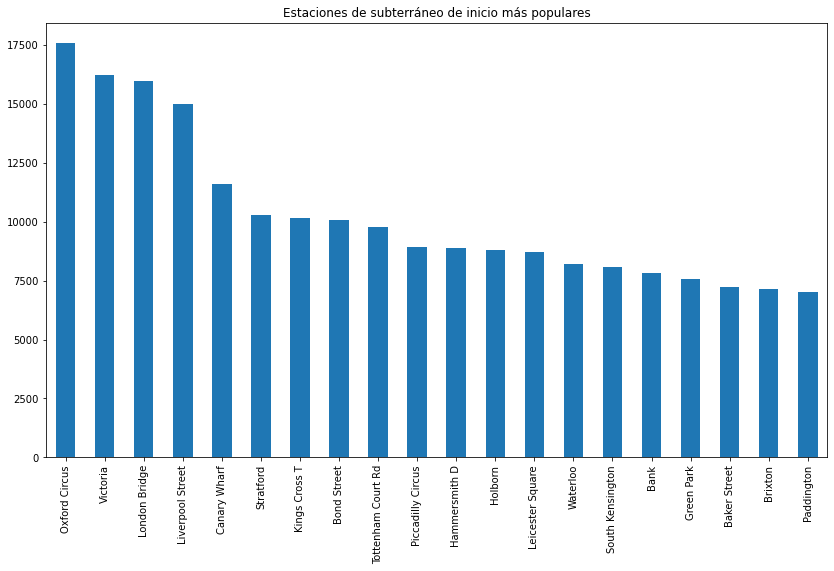

In [74]:
fig = plt.figure(figsize=[14,8])
plt.title('Estaciones de subterráneo de inicio más populares')
complete['StartStn'].value_counts()[:20].plot(kind='bar')

<AxesSubplot:title={'center':'Estaciones finales de metro más populares'}>

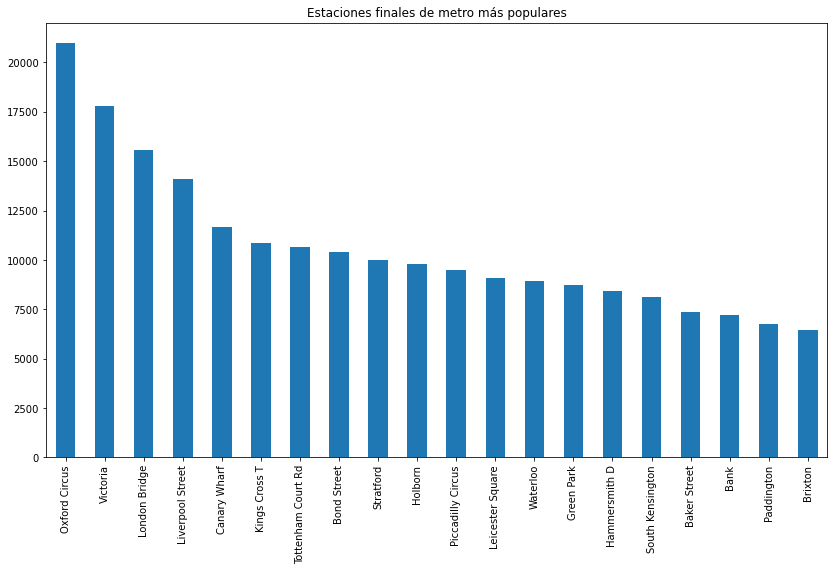

In [75]:
fig = plt.figure(figsize=[14,8])
plt.title('Estaciones finales de metro más populares')
complete['EndStn'].value_counts()[:20].plot(kind='bar')

In [76]:
complete[['StartStn','EndStn']].sample(10)

,StartStn,EndStn
862941,Canary Wharf DLR,Langdon Park
289434,Great Portland St,Harrow On The Hill
374531,Leicester Square,Tooting Broadway
198176,Bank,Shepherd's Bush Und
914082,Oxford Circus,Waterloo
1797661,Brixton,Elephant & Castle
702247,Kentish Town West,Hackney Central
486741,London Fields,Lambeth North
2500989,North Wembley,Wembley Central
1125825,Tufnell Park,Tooting Bec


## Comparación de estaciones de inicio y finalización
* Ahora crearemos un gráfico de frecuencia para todas las estaciones comparando Estación de inicio vs Estación final


In [77]:
from collections import OrderedDict

startstn = list(complete['StartStn'])
endstn = list(complete['EndStn'])
df = pd.DataFrame(data={'StartStn':startstn,'EndStn':endstn})
df.head()

,StartStn,EndStn
0,Goodge Street,Totteridge
1,Preston Road,Northwood
2,Holborn,Bounds Green
3,Earls Court,Pimlico
4,Victoria,Bethnal Green


In [78]:
# Create 'hue' column to use for plot

df['hue'] = 'Start' # set 'hue' to 'Start' for all Start stations
df['Stations'] = df['StartStn']
df_start = df[['Stations','hue']]

df['hue'] = 'End'   # set 'hue' to 'End' for all End stations
df['Stations'] = df['EndStn']
df_end = df[['Stations','hue']]

In [79]:
# Create order by value count

orderstart = df['StartStn'].value_counts()
startstnlist = orderstart.index.tolist()

orderend = df['EndStn'].value_counts()
endstnlist = orderend.index.tolist()

order = startstnlist+endstnlist
order = list(OrderedDict.fromkeys(order))

df_concat = pd.concat([df_start,df_end],ignore_index=True)

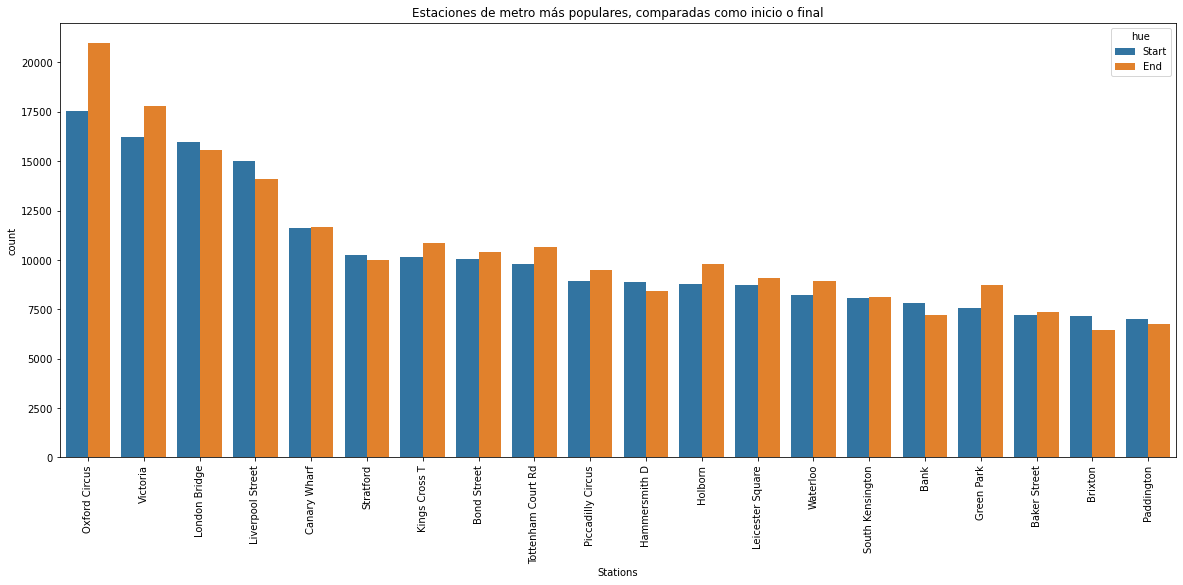

In [80]:
plt.figure(figsize=[20,8])
fig = sns.countplot(data=df_concat,x='Stations',order=order[:20],hue='hue')
plt.title('Estaciones de metro más populares, comparadas como inicio o final')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);

### Estaciones de metro más populares (Inicio or Final)
* Ahora veamos las estaciones de metro más populares, ya sean el punto de inicio o el final de un viaje.

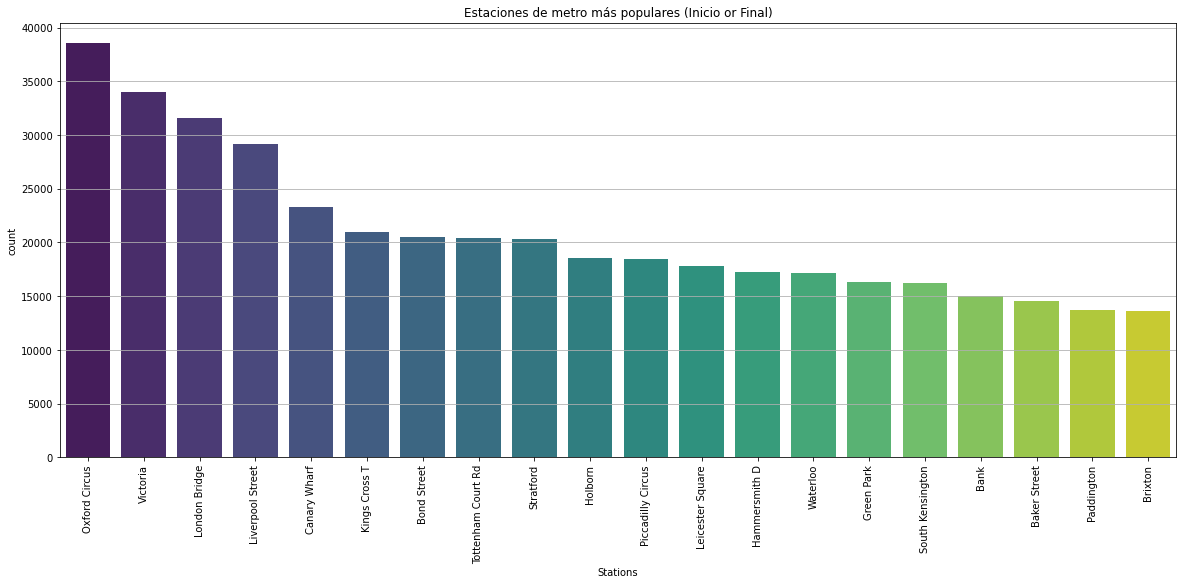

In [81]:
# Get order of all stations from df_concat
allstnlist = df_concat['Stations'].value_counts().index.tolist()
orderall = list(OrderedDict.fromkeys(allstnlist))

plt.figure(figsize=[20,8])
plt.grid()
plt.title('Estaciones de metro más populares (Inicio or Final)')
fig = sns.countplot(x='Stations',data=df_concat,order=orderall[:20],palette='viridis')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);

## Distribución de la duración del viaje
* Ahora investiguemos la distribución de la duración de los viajes en la red.

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Porcentaje de viajes totales')

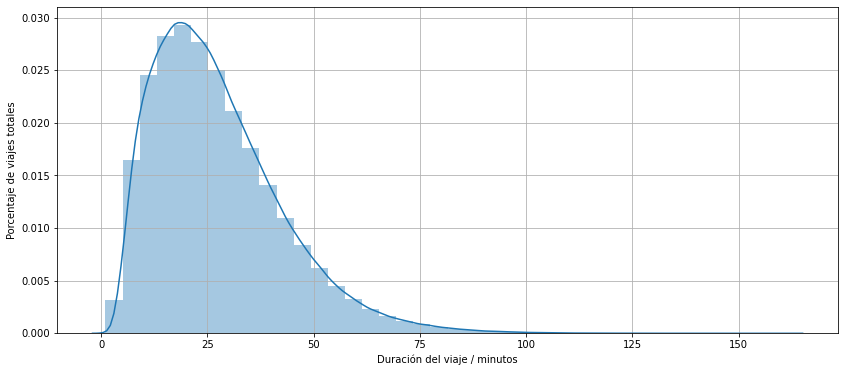

In [82]:
plt.figure(figsize=[14,6])
plt.grid()
ax = sns.distplot(complete['JourneyLength'],bins=40)
ax.set_xlabel('Duración del viaje / minutos')
ax.set_ylabel('Porcentaje de viajes totales')

* La gráfica de distribución muestra un sesgo positivo
* Podemos ver que la duración media del viaje es de unos 20 minutos.

## Comparar días de la semana
* Ahora veamos una gráfica de frecuencia según el día de la semana.

In [83]:
daysofweek = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

Text(0, 0.5, 'Número de viajes')

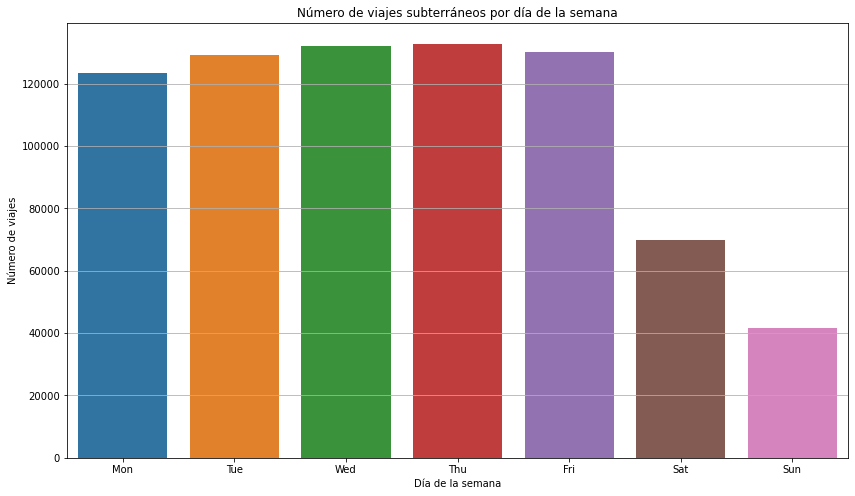

In [84]:
plt.figure(figsize=[14,8])
plt.grid()
sns.countplot(x='DOW',data=complete, order = daysofweek)
plt.title('Número de viajes subterráneos por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Número de viajes')

Como era de esperar, la mayoría de los viajes se realizan de lunes a viernes, en menor medida los sábados y menor aún los domingos.

# Step 3: Preprocesamiento
* Ahora prepararemos los datos para modelar, crear variables lógicas y descartar características redundantes

In [85]:
# Crear variable lógica de limitación diaria
complete['DailyCapping'] = pd.get_dummies(complete['DailyCapping'])['Y']

* Ahora miramos las diferentes entradas de Producto final para encontrar valores atípicos y entradas erróneas.

<AxesSubplot:>

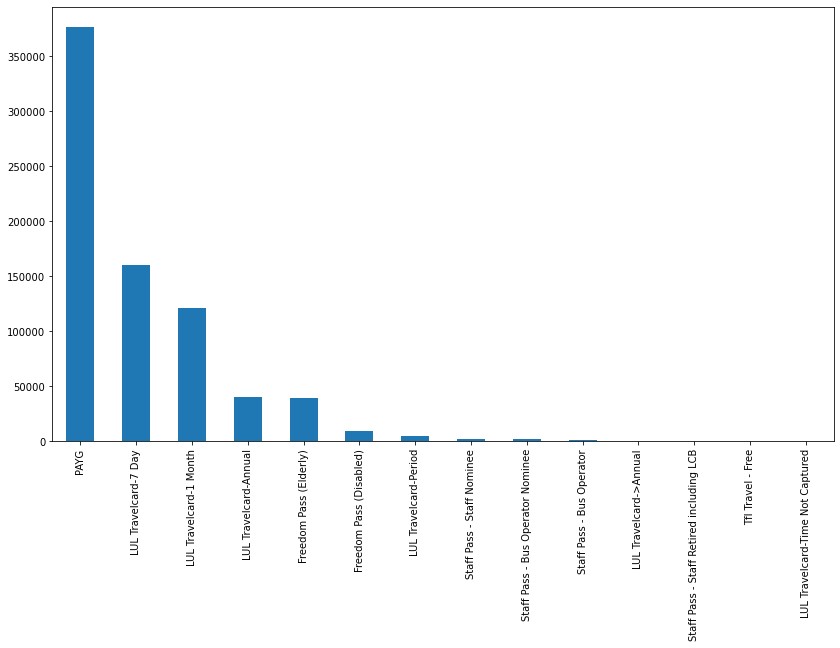

In [86]:
plt.figure(figsize=[14,8])
complete['FinalProduct'].value_counts().plot(kind='bar')

In [87]:
complete['FinalProduct'].value_counts()

PAYG                                        376020
LUL Travelcard-7 Day                        160291
LUL Travelcard-1 Month                      121245
LUL Travelcard-Annual                        40630
Freedom Pass (Elderly)                       39835
Freedom Pass (Disabled)                       9360
LUL Travelcard-Period                         4907
Staff Pass - Staff Nominee                    2606
Staff Pass - Bus Operator Nominee             1996
Staff Pass - Bus Operator                     1220
LUL Travelcard->Annual                         636
Staff Pass - Staff Retired including LCB       420
Tfl Travel - Free                              199
LUL Travelcard-Time Not Captured                 2
Name: FinalProduct, dtype: int64

In [88]:
complete[complete['FinalProduct'] == 'Tfl Travel - Free']

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,ExTime,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,FinalProduct,JourneyLength
56753,3,Tue,LUL,Gloucester Road,Hammersmith D,1003,1014,Z0110,TKT,0,0,0,Tfl Travel - Free,11
78555,6,Fri,LUL,West Acton,Latimer Road,1009,1029,Z0110,TKT,0,0,0,Tfl Travel - Free,20
96246,1,Sun,LUL,Hounslow East,Walthamstow Central,1015,1089,Z0110,TKT,0,0,0,Tfl Travel - Free,74
128455,3,Tue,LUL/DLR,Woolwich Arsenal DLR,Angel,1024,1078,Z0110,TKT,0,0,0,Tfl Travel - Free,54
130032,4,Wed,NR/LRC,Kenton,Wembley Central,1024,1040,Z0110,TKT,0,0,0,Tfl Travel - Free,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562997,2,Mon,LUL,Snaresbrook,Woodford,981,997,Z0110,TKT,0,0,0,Tfl Travel - Free,16
2565739,7,Sat,LUL,Holland Park,White City,982,990,Z0110,TKT,0,0,0,Tfl Travel - Free,8
2566410,5,Thu,LUL,Snaresbrook,Woodford,982,997,Z0110,TKT,0,0,0,Tfl Travel - Free,15
2566866,6,Fri,LUL,Ealing Common,South Kensington,982,1011,Z0110,TKT,0,0,0,Tfl Travel - Free,29


* Como podemos ver, 'LUL Travelcard->Annual' es una entrada coincidente inconsistente con 'LUL Travelcard-Annual'. Se cambiará el nombre de estas entradas para que sean coherentes con el resto de los datos.
* Se eliminan los dos valores atípicos donde no se capturó el tiempo de la tarjeta de viaje ('LUL Travelcard-Time Not Captured').
* No está claro qué se entiende por 'Tfl Travelcard - Free'. Intuimos que esto representa viajes gratuitos en los que los pasajeros utilizaron 5-10 tarjetas fotográficas Zip Oyster. La página de wikipedia de la tarjeta Oyster confirma que estas tarjetas Oyster estaban disponibles en 2009, cuando se recopilaron los datos:
> "El 7 de enero de 2008, Transport for London presentó la tarjeta Zip, una tarjeta fotográfica Oyster para jóvenes de 18 años o menos que califiquen para viajes gratuitos en autobús y tranvía dentro de la capital, a partir del 1 de junio de 2008."
[ [3] ](https://en.wikipedia.org/wiki/Oyster_card#Oyster_photocards) 

In [89]:
# Rename typo entries
complete['FinalProduct'].replace('LUL Travelcard->Annual','LUL Travelcard-Annual', inplace=True)

In [ ]:
# Eliminamos las entradas atípicas en las que faltaba el período de la tarjeta de viaje
complete = complete[complete['FinalProduct'] != 'LUL Travelcard-Time Not Captured']

In [ ]:
complete['FinalProduct'].value_counts()

# Conclusion
* Del análisis se puede concluir que ciertas estaciones están sometidas a un mayor estrés para acomodar a los pasajeros durante las horas pico. Un ejemplo de ello es Oxford Circus.
* La mayoría de las estaciones que experimentan una gran congestión se encuentran en la Zona 1.
*Es aconsejable encontrar un método para compartir la carga de pasajeros que llevan estas estaciones congestionadas con otras estaciones cercanas. Quizás proporcionar incentivos para que los pasajeros salgan en una estación menos congestionada y completen su viaje a pie o en autobús, por ejemplo.
* Se limpiaron los datos, se realizó EDA y algunos preprocesos básicos para prepararlos para el modelado.
* Ahora podría realizar una reducción de dimensionalidad en el marco de datos 'complete', quizás usando PCA (Principal Component Analysis), para sacar algunas conclusiones más interesantes. Puedo explorar esta posibilidad en el futuro.

# Referencias
[ [1] ](https://www.london.gov.uk/what-we-do/planning/london-plan/current-london-plan/london-plan-chapter-one-context-and-strategy-0) The London Plan 2011: https://www.london.gov.uk/what-we-do/planning/london-plan/current-london-plan/london-plan-chapter-one-context-and-strategy-0

[ [2] ](https://worldpopulationreview.com/world-cities/london-population/) 2020 London Population estimate according to Worldpopulationreview: https://worldpopulationreview.com/world-cities/london-population/

[ [3] ](https://en.wikipedia.org/wiki/Oyster_card#Oyster_photocards) Oyster photocards Wikipedia link: https://en.wikipedia.org/wiki/Oyster_card#Oyster_photocards